## Demo for Machine Learning and Pattern Recognition guest lecture, University of Edinburgh, 18.10.2017.

**John Quinn**

Classify image patches taken from a microscope with stained blood smear slides, to determine which of them contain plasmodium (the parasite which causes malaria).

<img src="http://air.ug/microscopy/image-capture-mulago.jpg" alt="Phone mounted on microscope" style="height: 400px; clear:both"/>

<p style="text-align: center;">**Lab technician at Mulago National Referral Hospital, Kampala**</p>



<img src="http://air.ug/microscopy/phone_mount.jpg" alt="Phone mounted on microscope" style="height: 400px;"/>

<p style="text-align: center;">**Image capture with a phone mounted on a microscope**</p>

<img src="http://air.ug/microscopy/plasmodium_field_of_view.jpg" style="height: 400px;"/>

<p style="text-align: center;">**Field of view containing plasmodium (malaria parasite)**</p>


In [1]:
from sklearn import model_selection, neighbors, metrics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load a dataset of blood smear image patches, with labels corresponding to the presence of absence of plasmodium. 

Each is a 40x40 pixel patch taken from an image such as those above, and contains either one of more plasmodium or some other non-plasmodium object such as a white blood cell or staining artifact.

In [2]:
data = np.load('malaria-classification-example.npz')
X = data['X']
y = data['y']
images = data['images']

print('Loaded {0} images and labels.'.format(X.shape[0]))

Loaded 2000 images and labels.


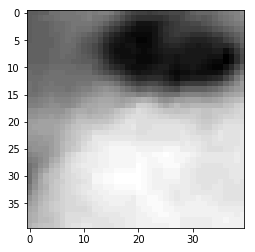

In [3]:
imshow(images[0],cmap=cm.gray)

In [4]:
print('Class: {0}'.format(y[0]))
X[0]

Class: 0.0


array([ 131.,  131.,  132., ...,  161.,  161.,  161.])

### Show sample images from each class

It's always important to try to look at classification data in as many ways as possible. Start by viewing samples from class 1 (containing plasmodium):

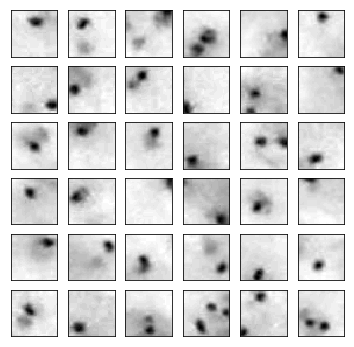

In [5]:
pos = np.where(y==1)[0]
figsize(6,6)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.imshow(images[pos[i],:,:], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])

Now show sample images from class 0

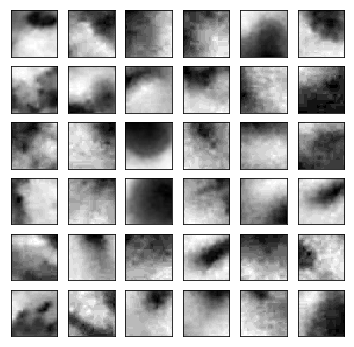

In [6]:
neg = np.where(y==0)[0]
figsize(6,6)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.imshow(images[neg[i],:,:], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])

### Train and test a  classifier

First, we split up the data into training and testing sets.

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Finding the nearest neighbour of an input point is one simple principle that we can use for classification. 

Have a look at some input images and their corresponding nearest neighbour in the training set:

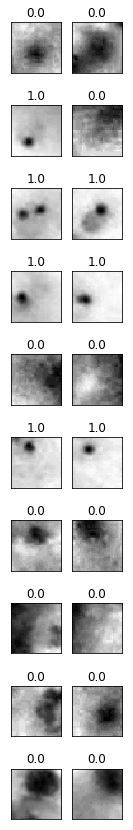

In [8]:
nn = neighbors.NearestNeighbors(n_neighbors=1)
nn.fit(X_train)

N_examples = 10
figsize(2,15)
for i in range(N_examples):
    subplot(N_examples,2,2*i+1)
    plt.imshow(np.reshape(X_test[i,:],(40,40)), cmap=plt.cm.gray)
    plt.title(y_test[i])
    plt.xticks([])
    plt.yticks([])
    
    subplot(N_examples,2,2*i+2)
    neighbour_idx = int(nn.kneighbors(X_test[i,:].reshape(1,-1))[1])
    plt.imshow(np.reshape(X_train[neighbour_idx,:],(40,40)), cmap=plt.cm.gray)
    plt.title(y_train[neighbour_idx])
    plt.xticks([])
    plt.yticks([])

Train a nearest neighbour classifier and look at the Receiver Operating Characteristics curve to understand its performance.

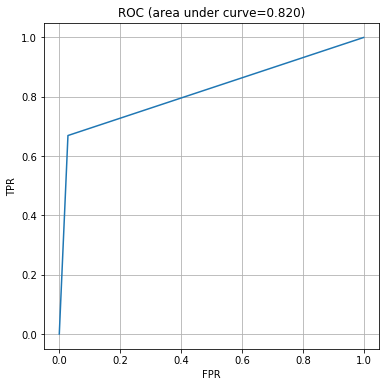

In [9]:
clf = neighbors.KNeighborsClassifier(n_neighbors=1, weights='distance')
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:,1]
 
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

figsize(6,6)
plot(fpr, tpr)
title('ROC (area under curve=%.3f)' % (metrics.roc_auc_score(y_test, y_pred)))
xlabel('FPR')
ylabel('TPR')
grid(True)

Try out different parameter values and look at which ones do best:

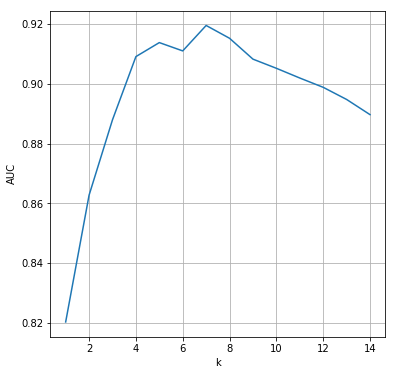

In [10]:
score = []
max_k = 15
for k in range(1,max_k):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance')
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    score.append(metrics.roc_auc_score(y_test,y_pred))
    
plot(range(1,max_k),score)
grid(True)
plt.xlabel('k')
plt.ylabel('AUC')

Looking at the mistakes that a classifier makes is a useful way to understand the way that it works, and what can be done to improve it. Show the neighbours for test images where the classifier was wrong.

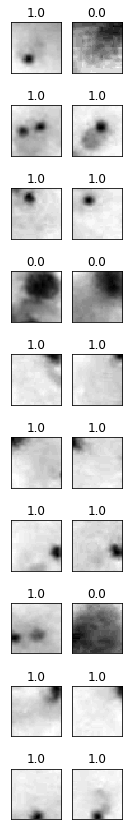

In [11]:
mistakes = np.where(np.logical_xor(y_pred>.5,y_test))[0]

nn = neighbors.NearestNeighbors(n_neighbors=1)
nn.fit(X_train)

N_examples = 10
figsize(2,15)
for i in range(N_examples):
    subplot(N_examples,2,2*i+1)
    plt.imshow(np.reshape(X_test[mistakes[i],:],(40,40)), cmap=plt.cm.gray)
    plt.title(y_test[mistakes[i]])
    plt.xticks([])
    plt.yticks([])
    
    subplot(N_examples,2,2*i+2)
    neighbour_idx = int(nn.kneighbors(X_test[mistakes[i],:].reshape(1,-1))[1])
    plt.imshow(np.reshape(X_train[neighbour_idx,:],(40,40)), cmap=plt.cm.gray)
    plt.title(y_train[neighbour_idx])
    plt.xticks([])
    plt.yticks([])

Have a look at how the test error varies with the training set size

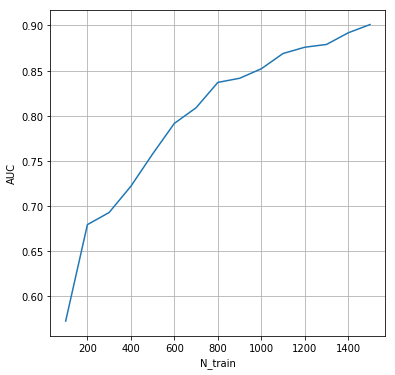

In [17]:
score = []
train_set_size = np.arange(100,X_train.shape[0]+1,100)
k = 5
for N_train in train_set_size:
    clf = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    clf.fit(X_train[:N_train,:], y_train[:N_train])
    y_pred = clf.predict_proba(X_test)[:,1]
    score.append(metrics.roc_auc_score(y_test,y_pred))
    
figsize(6,6)
plot(train_set_size,score)
grid(True)
xlabel('N_train')
ylabel('AUC')

### Looks like the performance would keep going up if we had access to more training data... 

We can get some for free by "augmenting" the dataset, creating rotated and flipped versions.

In [13]:
images_aug = []
y_train_aug = []
X_train_aug = []

for i in range(y_train.shape[0]):
    for n_rotations in range(4):
        for n_flips in range(2):
            new_image = X_train[i].reshape(40,40)
            if n_flips==1:
                new_image = np.fliplr(new_image)
            for i_rotation in range(n_rotations):
                new_image = np.rot90(new_image)
            images_aug.append(new_image)
            y_train_aug.append(y_train[i])
            X_train_aug.append(new_image.ravel())
            
X_train = np.array(X_train)

Let's have a look some of the augmented data.

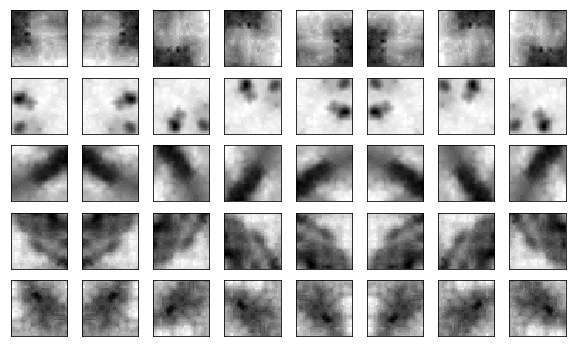

In [14]:
figsize(10,6)
for i in range(5*8):
    plt.subplot(5,8,i+1)
    plt.imshow(images_aug[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])

What performance do we get when we use the augmented training set?

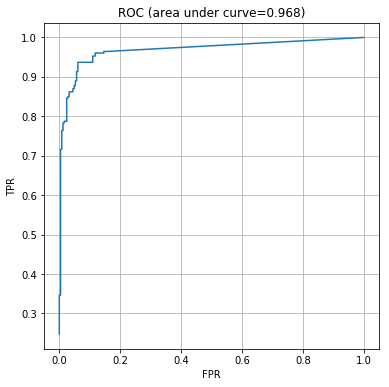

In [20]:
clf = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')
clf.fit(X_train_aug, y_train_aug)
y_pred = clf.predict_proba(X_test)[:,1]
 
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

figsize(6,6)
plot(fpr, tpr)
title('ROC (area under curve=%.3f)' % (metrics.roc_auc_score(y_test, y_pred)))
xlabel('FPR')
ylabel('TPR')
grid(True)

### Other models

Perhaps nearest neighbour is not the most effective classification model for this problem. We can try others:

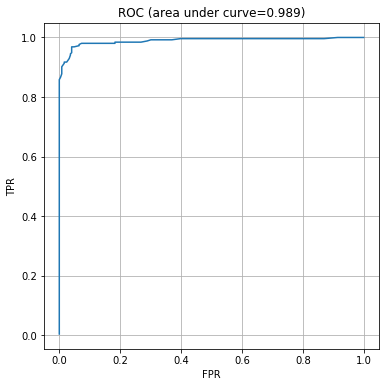

In [21]:
from sklearn import ensemble, linear_model
clf = ensemble.ExtraTreesClassifier(n_estimators=100)  # replace this with any sklearn classifier
clf.fit(X_train_aug, y_train_aug)
y_pred = clf.predict_proba(X_test)[:,1]
 
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

figsize(6,6)
plot(fpr, tpr)
title('ROC (area under curve=%.3f)' % (metrics.roc_auc_score(y_test, y_pred)))
xlabel('FPR')
ylabel('TPR')
grid(True)

### Models that work well with image data

For classification of images, the best types of models are those which take into account that the inputs are pixels which can be viewed on a grid, and don't just assume that every input dimension is completely independent of the others. This is one reason that convolutional networks are often effective for this sort of problem.

See how that's done here: https://github.com/jqug/microscopy-object-detection

And if you're interested, get all the code and data, and read more about it here: http://air.ug/microscopy/